In [1]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import *
from src.tree import * 
import matplotlib.cm 
import matplotlib.colors
from scipy.stats import chisquare
from scipy.spatial.distance import cdist
import src.tools as tools
from Bio import Phylo
from src.coevolution import *
from src.stop_codon import _get_stop_codon_genome_metadata_info, build_stop_codon_genome_metadata_dataset
from Bio.Seq import Seq
from Bio import Align 

%load_ext autoreload
%autoreload 2


In [2]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)

# build_stop_codon_genome_metadata_dataset(arf1_df.genome_id.unique(), fn_dir='../data/ncbi/genomes', path='../data/arf1_stop_codon_metadata.csv')

stop_codon_genome_metadata_df = pd.read_csv('../data/arf1_stop_codon_metadata.csv', index_col=0)
arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count

gtdb_metadata_df = pd.read_csv('../data/ar53_metadata_r226.tsv', sep='\t', index_col=0)
gtdb_metadata_df.index = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in gtdb_metadata_df.index]
gtdb_metadata_df = gtdb_metadata_df.loc[arf1_df.genome_id].copy()
gtdb_metadata_df['species'] = [re.search(r's__(.+)', taxonomy).group(1) for taxonomy in gtdb_metadata_df.gtdb_taxonomy]

arf1_df['species'] = arf1_df.genome_id.map(gtdb_metadata_df.species)


In [3]:

# I think more granular categories could be helpful:
# (1) Pyl+ and largely re-coded (TAG < 5%)
# (2) Pyl+ which still use lots of TAG stops (TAG > 5%) 
# (3) Pyl- (including the weird outliers

masks = dict()
masks['pyl+ recoded'] = (arf1_df.tag_percent < 0.05) & (arf1_df.has_pyl)
masks['pyl+'] = (arf1_df.tag_percent >= 0.05) & (arf1_df.has_pyl)
masks['pyl-'] = (~arf1_df.has_pyl)

categories = list(masks.keys())
arf1_df['category'] = np.select([masks[category] for category in categories], categories, default='none')

for category, df in arf1_df.groupby('category'):
    print(f'Num. sequences in category {category}:', len(df))

Num. sequences in category pyl+: 73
Num. sequences in category pyl+ recoded: 90
Num. sequences in category pyl-: 2326


In [4]:
# # Want to double-check the aRF1 E-values, as cannot rule out the possibility that some of the
# # sequences which made it into the dataset are aRF1-2s. 
# figure_df = arf1_df.copy()

# fig, ax = plt.subplots()
# figure_df = figure_df[figure_df.order == 'Methanosarcinales'].copy()
# sns.ecdfplot(figure_df, x='e_value', hue='category')
# ax.set_xscale('log')
# # ax.set_xlim(xmax=1e-156, xmin=-1e-150)

# # I suspect that these E-value differences are mainly phylogenetic, but would be good to confirm. 


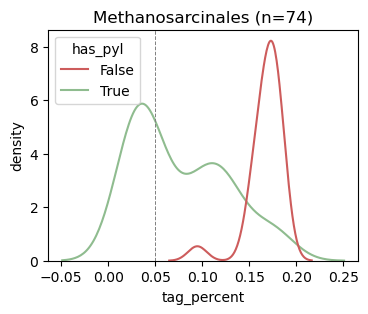

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))

stop_codons = ['TAA', 'TGA', 'TAG']
palette = {True:'darkseagreen', False:'indianred'}

figure_df = arf1_df.copy()
figure_df = figure_df[figure_df.order == 'Methanosarcinales'].copy()
sns.kdeplot(figure_df, x='tag_percent', hue='has_pyl', palette=palette)
ax.set_ylabel('density')
ax.axvline(x=0.05, ls='--', color='gray', lw=0.7)
ax.set_title(f'Methanosarcinales (n={len(figure_df)})')

plt.show()

# Among Pyl+ archaea, when the TAG content drops below 5%, the extension length spikes. This seems like a reasonable threshold for 
# choosing organisms which might have aRF1 changes. 
 
# When the TAG content is higher, the extension lengths are generally lower. In this scenario, we might not expect the 
# release factor to look very different. Genomes are robust to Pyl incorporation and stop codon readthrough. 

# When the TAG content is lower, extension lengths are higher. In these genomes, it may
# be the case that the genomes have fully adapted to frequent Pyl; these are probably the "recoded" genomes.

In [6]:
arf1_df = arf1_df[arf1_df.order == 'Methanosarcinales'].copy()
print(f'Removing all non-Methanosarcinales organisms from the DataFrame. {len(arf1_df)} sequences remaining.')

tree = tree_load_ar53(genome_ids=arf1_df.genome_id.unique())
tree_write(tree, '../data/arf1_methanosarcinales_ar53.tree')
tree_relabel('../data/arf1_methanosarcinales_ar53.tree', '../data/arf1_methanosarcinales_ar53_species.tree', label_map=arf1_df.set_index('genome_id').species.to_dict())

FASTAFile().from_df(arf1_df.set_index('genome_id')).write('../data/arf1_methanosarcinales.fa') # Use the genome ID as an identifier. 


# run_muscle('../data/arf1_methanosarcinales.fa', build_tree=False)

styles = {row.genome_id:'bold' for row in arf1_df[arf1_df.has_pyl].itertuples()}
sizes = {row.genome_id:2 for row in arf1_df[arf1_df.has_pyl].itertuples()}
tools.make_itol_annotation_file(arf1_df.set_index('genome_id'), field='tag_percent', path='../data/itol/arf1_methanosarcinales_tag_percent_annotation.txt', styles=styles, sizes=sizes)

styles = {row.species:'bold' for row in arf1_df[arf1_df.has_pyl].itertuples()}
sizes = {row.species:2 for row in arf1_df[arf1_df.has_pyl].itertuples()}
tools.make_itol_annotation_file(arf1_df.set_index('species'), field='tag_percent', path='../data/itol/arf1_methanosarcinales_species_tag_percent_annotation.txt', styles=styles, sizes=sizes)

# palette = {'R':red, 'K':darkblue, 'M':darkgreen, '-':gray}
# tools.make_itol_annotation_file(arf1_df, field='residue_8', path='../data/methanosarcinales_arf1_tree_annotation_residue_8.txt', palette=palette)

palette = {'pyl+ recoded':darkgreen, 'pyl-':red, 'pyl+':lightblue}
tools.make_itol_annotation_file(arf1_df, field='category', path='../data/itol/arf1_methanosarcinales_category_annotation.txt', palette=palette)

Removing all non-Methanosarcinales organisms from the DataFrame. 74 sequences remaining.


In [7]:
def annotate_residues(annotations:dict, ax=None, lines_only:bool=False):
    for seq, (start, stop) in annotations.items():
        positions = np.arange(start, stop)
        for x, aa in zip(positions, list(seq)):
            if not lines_only:
                ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
            ax.axvline(x, ls='--', lw=0.5, color='gray')


index, alignment = load_msa(path='../data/arf1_methanosarcinales.afa', ids=arf1_df.genome_id.values) # Should load the sequences from Methanosarcinales only. 
alignment_df = pd.DataFrame(alignment, index=index)
alignment_df['has_pyl'] = arf1_df.has_pyl
alignment_df['category'] = arf1_df.category

seq = ''.join(alignment[0])
domain_boundaries = get_domain_boundaries(seq)


get_domain_boundaries: NIKS boundaries 55-59.
get_domain_boundaries: YxCxxxF boundaries 118-125.
get_domain_boundaries: GTS boundaries 23-26.


Num. re-coded neighbors: 12
get_domain_boundaries: NIKS boundaries 55-59.
get_domain_boundaries: YxCxxxF boundaries 119-126.
get_domain_boundaries: GTS boundaries 23-26.


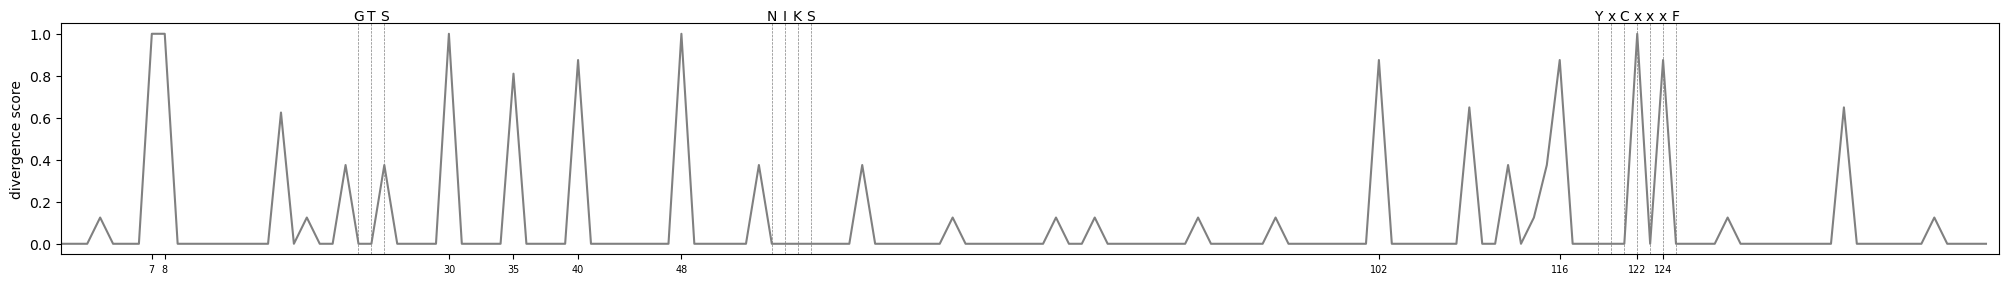

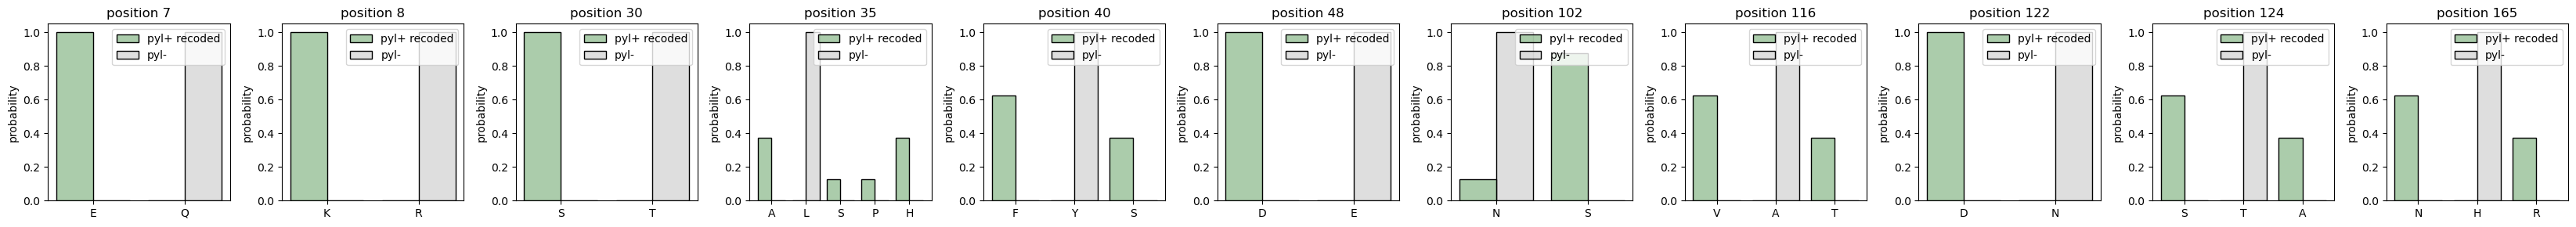

In [16]:
weird_id = 'GCA_003164755.1' # Use genome IDs for accesing the tree. 
weird_neighbors = tree.get_path(tree.find_any(weird_id))[-5].get_terminals() # Look three branch points back and grab the leaves of the internal node.
print('Num. re-coded neighbors:', len(weird_neighbors) - 1)

weird_neighbor_ids = [node.name for node in weird_neighbors]
weird_genome_neighbor_distances = [tree.distance(tree.find_any(weird_id), node) for node in weird_neighbor_ids]

weird_arf1_df = arf1_df[arf1_df.genome_id.isin(weird_neighbor_ids)].copy()

index, alignment = load_msa('../data/arf1_methanosarcinales.afa', ids=weird_neighbor_ids)

seq = ''.join(alignment[0])
domain_boundaries = get_domain_boundaries(seq)

figure_df = pd.DataFrame(alignment[:, :200], index=index)
figure_df['category'] = weird_arf1_df.set_index('genome_id').category
figure_df = figure_df[figure_df.category.isin(['pyl+ recoded', 'pyl-'])].copy()

fig, ax = plt.subplots(figsize=(25, 3))

divergence_scores = get_scores(figure_df, group_by='category')
plot_scores_1d(divergence_scores, ax=ax, y_label='divergence score', color='gray')
annotate_residues(domain_boundaries, ax=ax)

ax.set_xticks(np.where(divergence_scores > 0.8)[0])
ax.set_xlim(xmax=150)

# for category, df in figure_df.groupby('category'):
#     print(f'Num. sequences in category {category}:', len(df))

positions = np.where(divergence_scores > 0.8)[0].tolist()

palette = {'pyl+ recoded':'darkseagreen', 'pyl-':'lightgray'}
palette = {'pyl+ recoded':'darkseagreen', 'pyl-':'lightgray'}

fig, axes = plt.subplots(figsize=(3 * len(positions), 3), ncols=len(positions))
for ax, position in zip(axes.ravel(), positions):
    plot_residue_counts(figure_df, position=position, ax=ax, hue='category', palette=palette)
fig.tight_layout()
plt.show()


In [9]:


def map_index_to_human_arf1(seq:str)
    human_arf1_seq = 'MKQDVLNCTEGPIHSNGTSMISLIIPPKDQISRVAKMLADEFGTASNIKSRVNRLSVLGAITSVQQRLKLYNKVPPNGLVVYCGTIVTEEGKEKKVNIDFEPFKPINTSLYLCDNKFHTEALTALLSDDSKFGFIVIDGSGALFGTLQGNTREVLHKFTVDLPKKHGRGGQSALRFARLRMEKRHNYVRKVAETAVQLFISGDKVNVAGLVLAGSADFKTELSQSDMFDQRLQSKVLKLVDISYGGENGFNQAIELSTEVLSNVKFIQEKKLIGRYFDEISQDTGKYCFGVEDTLKALEMGAVEILIVYENLDIMRYVLHCQGTEEEKILYLTPEQEKDKSHFTDKETGQEHELIESMPLLEWFANNYKKFGATLEIVTDKSQEGSQFVKGFGGIGGILRYRVDFQGMEYQGGDDEFFDLDDY'

    aligner = Align.PairwiseAligner()
    aligner.gap_score = -2
    alignment = aligner.align(seq, human_arf1_seq)
    print(alignment[2])
    print(dir(alignment[2]))
    print(alignment[2].inverse_indices)

SyntaxError: expected ':' (1219584363.py, line 1)

In [ ]:
def get_distinct_residues(target_id:str, alignment_df=None, max_position:int=200):
    # Remove the metadata columns. 
    alignment_df = alignment_df[[col for col in alignment_df.columns if (type(col) == int)]].copy()
    target_residues = alignment_df.loc[target_id].values.reshape(-1, 1)
    other_residues = alignment_df[alignment_df.index != target_id].values.T
    positions = np.where(~np.any(target_residues == other_residues, axis=1))[0]
    positions = positions[positions < max_position].copy()
    return positions, alignment_df[positions].loc[target_id].values

# There are two residues in PLUB01000075.1_62 which are present in some Pyl- organisms, but not in any of the close relatives. 
# There are also several residues which are unique, both when compared to the Pyl- organisms and the close relatives. 
for target_id in target_ids:

    positions, residues = get_distinct_residues(target_id, alignment_df=alignment_df.loc[[target_id] + relative_ids].copy())
    info = [f'{position} ({residue})' for position, residue in zip(positions, residues)]
    print(f'Residues distinct between {target_id} and close relatives:', ', '.join(info))

    # positions, residues = get_distinct_residues(target_id, alignment_df=alignment_df.loc[[target_id] + pyl_minus_and_high_tag_ids].copy())
    # info = [f'{position} ({residue})' for position, residue in zip(positions, residues)]
    # print(f'Residues distinct between {target_id} and Pyl-, high TAG percent organisms:', ', '.join(info))


NameError: name 'target_ids' is not defined

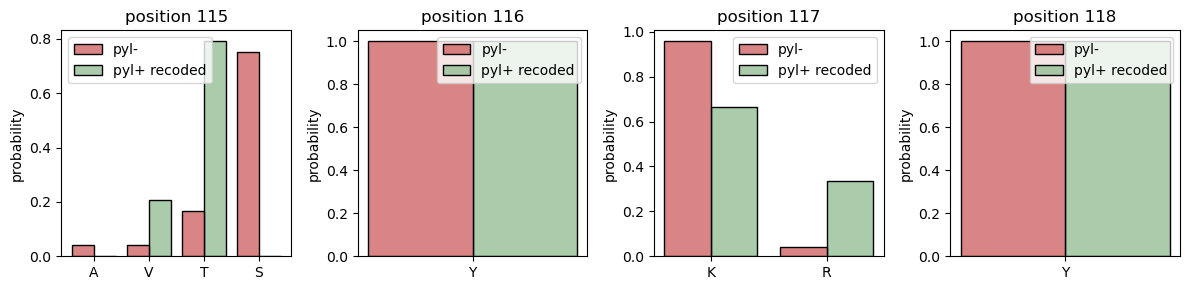

In [ ]:
outlier_ids = ['KADGNM010000028.1 7', 'PLUB01000075.1 62', 'JACIVZ010000083.1 3']
positions = [7, 8, 21, 35, 40, 115]
positions = [23, 24, 25]
# Among the N129 mutants, the most significant effect was observed for N129P ( Figure 2 D), which resulted in a 
# 10 and 40% termination efficiency increase at UAA and UGA, respectively. In contrast, the termination efficiency 
# of this mutant at UAG was decreased by up to 20%. 
positions = [115, 116, 117, 118]
# positions = [50, 51, 52, 53, 54]

palette = {'pyl+ recoded':'darkseagreen', 'pyl+':'steelblue', 'pyl-':'indianred'}
palette = {'pyl+ recoded':'darkseagreen', 'pyl-':'indianred'}

figure_df = alignment_df.copy()
figure_df['category'] = arf1_df.category 
figure_df = figure_df[~figure_df.index.isin(outlier_ids)].copy()
figure_df = figure_df[figure_df.category.isin(palette.keys())].copy() 


fig, axes = plt.subplots(figsize=(3 * len(positions), 3), ncols=len(positions))
for ax, position in zip(axes.ravel(), positions):
    plot_residue_counts(figure_df, position=position, ax=ax, hue='category', palette=palette)
fig.tight_layout()
plt.show()
# Instead of looking only at the close relatives, compare across all genomes. 

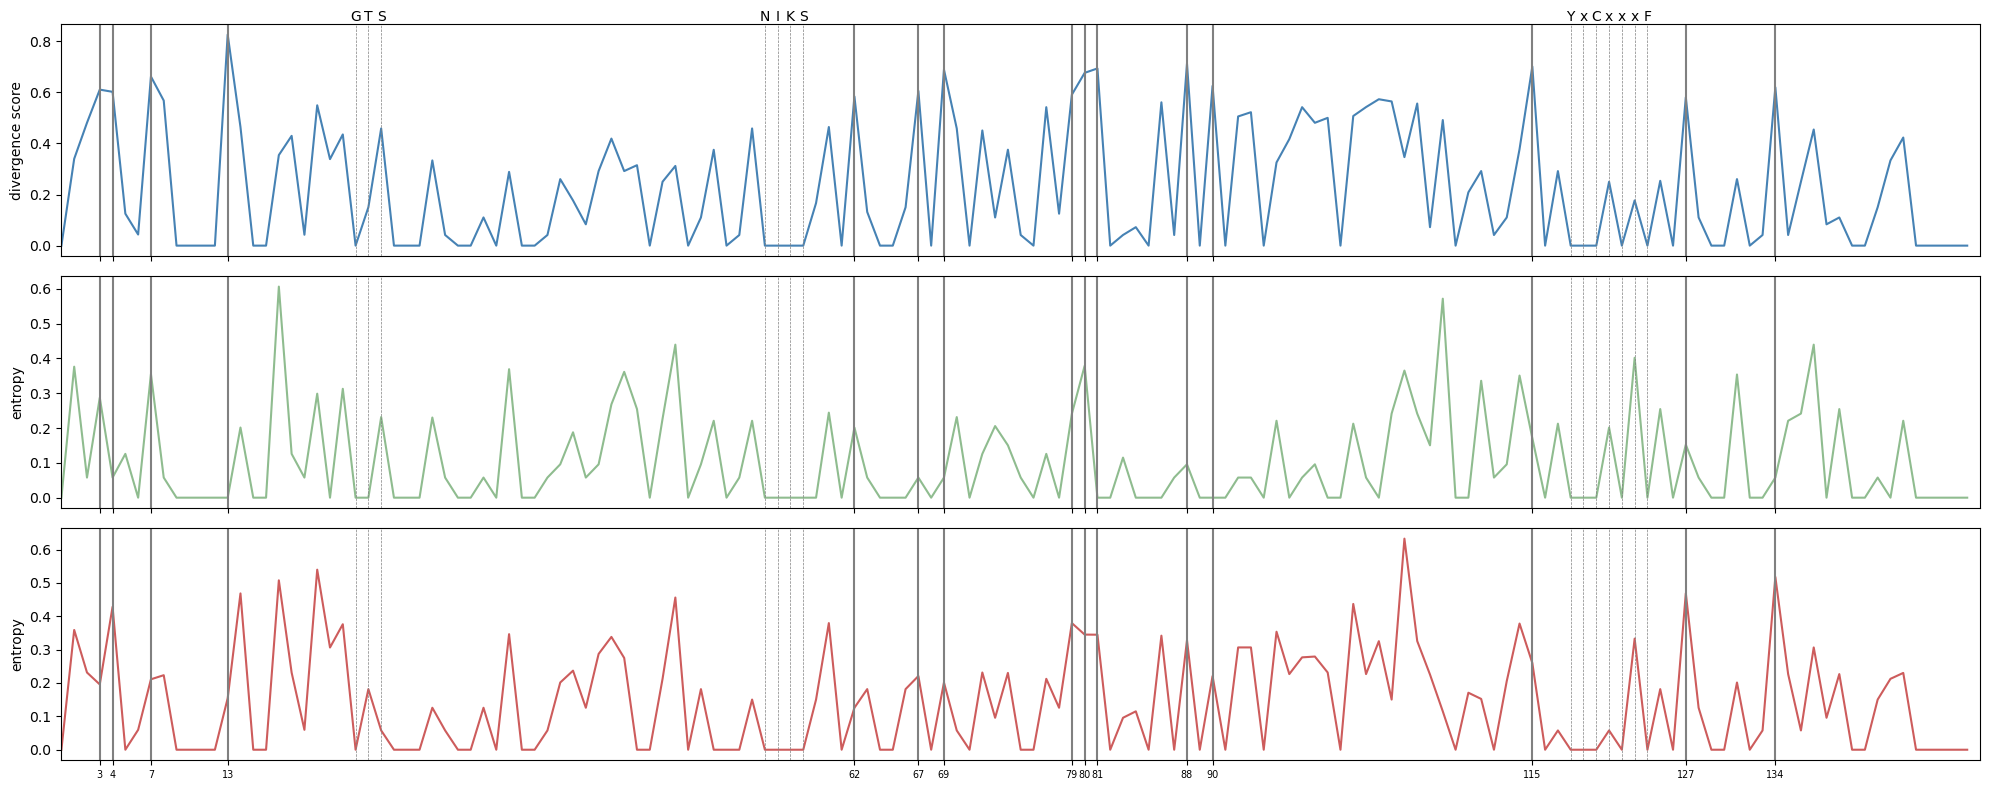

In [ ]:
outlier_ids = ['KADGNM010000028.1 7', 'PLUB01000075.1 62', 'JACIVZ010000083.1 3']

figure_df = alignment_df.copy()
figure_df = figure_df[figure_df.category.isin(['pyl+ recoded', 'pyl-'])]
figure_df = figure_df[~figure_df.index.isin(outlier_ids)].copy()

fig, (ax_a, ax_b, ax_c) = plt.subplots(figsize=(20, 8), nrows=3, sharex=True)

divergence_scores = get_scores(figure_df)
plot_scores_1d(divergence_scores, ax=ax_a, y_label='divergence score')
markers = np.argsort(divergence_scores[:150])[::-1][:15].tolist()
# print(' '.join(markers.astype(str)))
# markers += [7, 8, 21, 35, 40, 115] # Residues distinct between PLUB and close relatives. 
# markers += [21] # Residues distinct between PLUB and Pyl-
# markers += np.argsort(divergence_scores[:150])[::-1][:10].tolist()

plot_scores_1d(get_entropies(figure_df[figure_df.category == 'pyl+ recoded'])[0], ax=ax_b, y_label='entropy', color='darkseagreen')
plot_scores_1d(get_entropies(figure_df[figure_df.category == 'pyl-'])[0], ax=ax_c, y_label='entropy', color='indianred')

annotate_residues(domain_boundaries, ax=ax_a)
annotate_residues(domain_boundaries, ax=ax_b, lines_only=True)
annotate_residues(domain_boundaries, ax=ax_c, lines_only=True)

# for x in markers:
for ax in [ax_a, ax_b, ax_c]:
    for x in markers:
        ax.axvline(x, ls='-', color='gray')
ax_c.set_xticks(markers, labels=markers)

fig.tight_layout()
plt.show()
# What would be the maximum distance between two vectors that sum to one? sqrt(2)

# 7 8 35 40 115 

# Should note that the Pyl- group not as phylogenetically diverse as the Pyl+ group, so it is possible that residues which are conserved
# in the Pyl- group and not in the Pyl+ group may be due to phylogenetic signal. However, this also means that residues which are conserved
# in the Pyl+ group and not in the Pyl- group may be more more likely to be significant.

# We expect the recoded Pyl+ group to have changes to the release factor which weaken its ability to bind stop codons.  


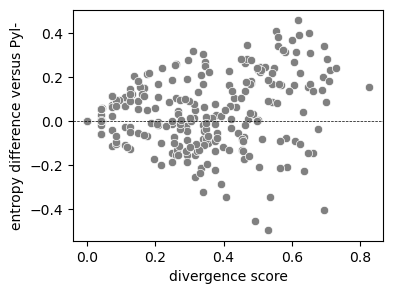

In [ ]:
# Is there any correlation between conservation within Pyl+ and the divergence metric? It seems like there should be, 
# based on quick inspection. 

fig, ax = plt.subplots(figsize=(4, 3))

outlier_ids = ['KADGNM010000028.1 7', 'PLUB01000075.1 62', 'JACIVZ010000083.1 3']

figure_df = alignment_df.copy()
figure_df = figure_df[figure_df.category.isin(['pyl+ recoded', 'pyl-'])]
figure_df = figure_df[~figure_df.index.isin(outlier_ids)].copy()

# palette = {'pyl+ recoded':'darkseagreen', 'pyl-':'indianred'}

# for category, df in figure_df.groupby('category'):
#     divergence_scores = get_scores(figure_df)
#     entropies = get_entropies(df)[0]
#     sns.scatterplot(x=divergence_scores, y=entropies, label=category, color=palette[category])

pyl_plus_recoded_entropies = get_entropies(figure_df[figure_df.category == 'pyl+ recoded'])[0]
pyl_minus_entropies = get_entropies(figure_df[figure_df.category == 'pyl-'])[0]
entropy_diffs = np.array(pyl_minus_entropies) - np.array(pyl_plus_recoded_entropies)
sns.scatterplot(x=divergence_scores, y=entropy_diffs, color='gray')

ax.set_ylabel('entropy difference versus Pyl-')
ax.set_xlabel('divergence score')

ax.axhline(0, color='black', lw=0.5, ls='--')
plt.show()

Generating plots for 15 positions.


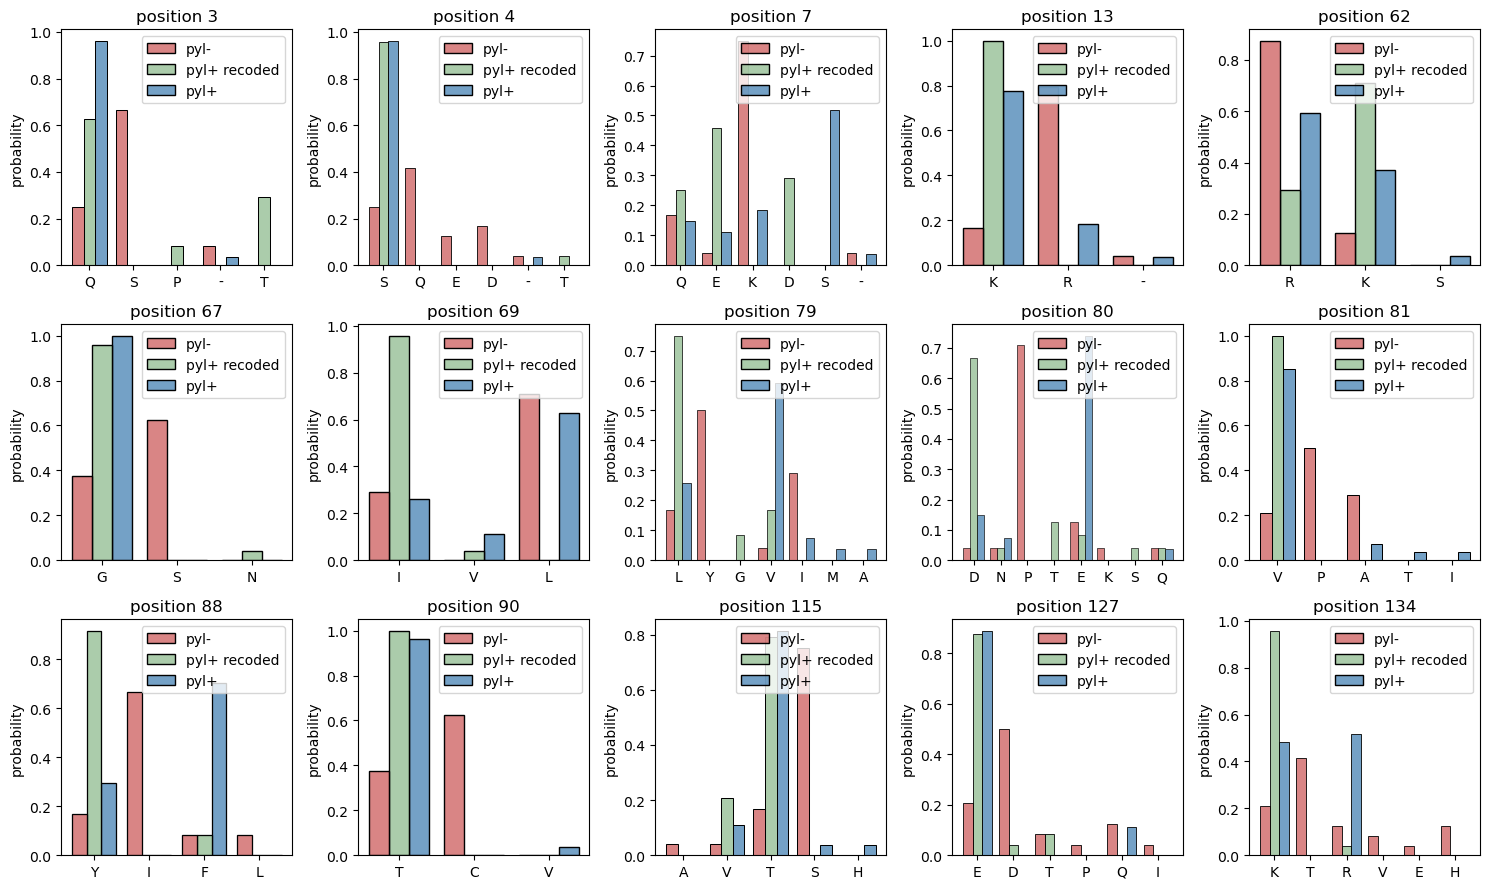

In [ ]:
outlier_ids = ['KADGNM010000028.1 7', 'PLUB01000075.1 62', 'JACIVZ010000083.1 3']
positions = sorted(markers)
print(f'Generating plots for {len(positions)} positions.')

figure_df = alignment_df.copy()
figure_df['category'] = arf1_df.category 
figure_df = figure_df[~figure_df.index.isin(outlier_ids)].copy()

palette = {'pyl+ recoded':'darkseagreen', 'pyl+':'steelblue', 'pyl-':'indianred'}

n_rows = 3 
n_cols = 5

fig, axes = plt.subplots(figsize=(3 * n_cols, 3 * n_rows), nrows=n_rows, ncols=n_cols)
for ax, position in zip(axes.ravel(), positions):
    plot_residue_counts(figure_df, position=position, ax=ax, hue='category', palette=palette)
fig.tight_layout()
plt.show()

In [ ]:
# No single signal, but perhaps if you look at the second-order scores, i.e. distribution of residue pairs?
# Worried about the mutual information metric, as it can be easily skewed by a single outlier

In [ ]:
# Downloaded and ran Prodigal on two genomes of Methanosarcina which (1) had Pyl (2) lost Pyl, and (3) 
# had their TAG usage revert back to the original form. If modifications in the release factor do play a role in 
# total re-coding, we would expect specific, conserved changes between aRF1 of these organisms and their closest relative_ids. 

# def add_weird_genomes(arf1_df, genome_ids=['GCA_003164755.1', 'GCA_017883485.1']):
#     arf1_ids = {'GCA_017883485.1':'JADGNM010000028.1_7',  'GCA_003164755.1':'PLUB01000075.1_62'} # From inspection of hmmer output files.
#     df = list()
#     for genome_id in genome_ids:
#         fn_path = f'../data/{genome_id}.fna'
#         fa_path = f'../data/{genome_id}.fa'

#         row = {'genome_id':genome_id, 'id':arf1_ids.get(genome_id), 'description':''}
#         row['has_pyl'] = False
#         row['order'] = 'Methanosarcinales'
#         row['genus'] = 'Methanosarcina'
#         stop_codon_info = _get_stop_codon_genome_metadata_info(fa_path=fa_path, fn_path=fn_path)
#         row['tag_percent'] = stop_codon_info['TAG'] / (stop_codon_info['TAG'] + stop_codon_info['TGA'] + stop_codon_info['TAA'])
#         row['gc_content'] = stop_codon_info['gc_content']
#         row['seq'] = FASTAFile().from_fasta(fa_path).to_df().loc[row['id']].seq
#         df.append(row)
#     df = pd.DataFrame(df).set_index('id')
#     arf1_df = pd.concat([df, arf1_df])
#     arf1_df = arf1_df[~arf1_df.index.duplicated(keep='first')].copy() # Make sure to not re-add if added. 
#     return arf1_df

# arf1_df = add_weird_genomes(arf1_df)

In [ ]:
# if not os.path.exists('scores_order_2.txt'):
#     cols = list(range(150)) + ['has_pyl']
#     mask = alignment_df.category.isin(['pyl+ recoded', 'pyl-'])
#     scores = get_scores(alignment_df[mask][cols].copy(), order=2)
#     with open('scores_order_2.txt', 'w') as f:
#         np.savetxt(f, scores)
# scores = np.loadtxt('scores_order_2.txt')

# Write scores comparing Pyl- and Pyl+ non-recoded, as well as Pyl+ and Pyl+ recoded. 

# DataFrame with the following fields:
# (1) score
# (2) position 
# (3) groups being compared
# (4) alignment length 
# groups = [('pyl+ recoded', 'pyl+'), ('pyl-', 'pyl+')]
# scores_df = list()
# for group_1, group_2 in groups:
#     scores = get_scores()

In [ ]:
# Want to see if there are any changes in the aRF1s of the weird genomes which lost Pyl which are (1) not present in any of the closely-related
# aRF1s and (2) are present in the organisms which have adapted to Pyl incorporation by reducing TAG. 

# tree = Phylo.read('../data/arf1_methanosarcinales.tree', format='newick')
# tree.root_at_midpoint()

# target_ids = ['JADGNM010000028.1_7', 'PLUB01000075.1_62']

# relative_ids = list()
# for target_id in target_ids:
#     path = tree.get_path(target_id)
#     node = path[-4] # Look four branches back. 
#     relative_ids += [leaf.name for leaf in node.get_terminals()]

# relative_ids = list(set(relative_ids))
# relative_ids.remove('PLUB01000075.1_62')
# relative_ids.remove('JADGNM010000028.1_7')

# pyl_minus_and_high_tag_ids = arf1_df[(arf1_df.tag_percent > 0.1) & ~arf1_df.has_pyl].index.tolist()
# pyl_minus_and_high_tag_ids.remove('PLUB01000075.1_62')
# pyl_minus_and_high_tag_ids.remove('JADGNM010000028.1_7')
